# Outline

1.   Basic motivation of hyperparameter tuning
2.   Integrating Google colab with a local runtime (config in Google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them


MLflow is open source project.
The jupyter/python code need to run locally and MLflow GUI will run locally.
MLflow is run is google colab with local runtime because the log file generated by MLflow cannot be opened in colab.

Google colab support version control using git.


Install MLflow
pip3 install mlflow

Command to open mlflow from terminal:
 <b>mlflow ui</b> 


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [2]:
import mlflow
import mlflow.pytorch

# Params

The hyperparameter of the NN are kept in the class Params. args is the instance of the class.

In [3]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

# Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

# Model

In [5]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
def train(epoch):
    #In training set the model to train by: model.train()
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [17]:
%mkdir images
%mkdir models

mkdir: cannot create directory ‘images’: File exists


Here we have created a confusion matrix. The confusion matrix is plotted between predicted output and the actual output. As there are 10 classes so thed confusion matrix will be 10 * 10(0-9 classes).

In [14]:
def test(epoch):
    #In test mode we set the model to evaluation by model.eval()
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = 'images/%s.png' % (expt_id)
            print(image_path)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop

Here we are creating an experiment id which consist of lr , momentum and hidden nodes.
The mlflow will start with:
    with mlflow.start_run() as run
    
 
mlflow.log_metric ----things that we compute like loss and accuracy.  
mlflow.log_param  ----parameters like learning rate,momentum and hidden nodes.



LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.913
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.582
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.436
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.365
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.290
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.260
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.232
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.437
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.312
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.207
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.325

Test set: Average loss: 0.0010, Accuracy: 9253/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.203
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.289
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.242
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.243
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.201
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.310
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.164
Train Epoch:


Test set: Average loss: 0.0009, Accuracy: 9322/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.223
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.217
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.205
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.112
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.302
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.201
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.177
Train Epoch: 2 [35840/60000 (60%)]	Loss: 0.141
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.160
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.227
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.183
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.149

Test set: Average loss: 0.0006, Accuracy: 9506/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.162
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.180
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.112
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.156
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.171
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.164
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.206


Test set: Average loss: 0.0005, Accuracy: 9644/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.137
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.103
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.105
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.063
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.110
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.093
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.136
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.105
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.097
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.154
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.043
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.095

Test set: Average loss: 0.0005, Accuracy: 9625/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.097
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.096
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.056
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.060
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.091
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.095
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.053


Test set: Average loss: 0.0004, Accuracy: 9673/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.083
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.064
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.082
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.098
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.064
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.085
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.118
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.107
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.154
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.116
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.061
Train Epoch: 4 [56320/60000 (94%)]	Loss: 0.070

Test set: Average loss: 0.0004, Accuracy: 9675/10000 (97%)

images/10_90_48.png

LR = 0.10, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.461
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.419
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.369
Train Epoch: 1 [25600/600

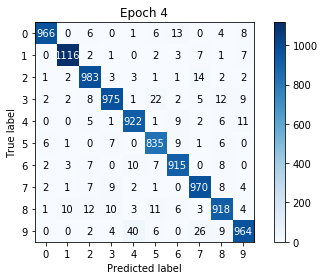

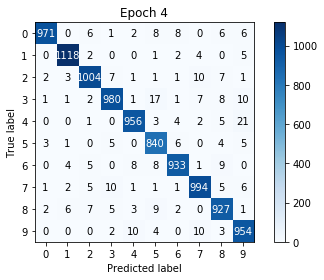

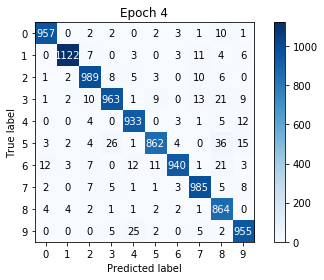

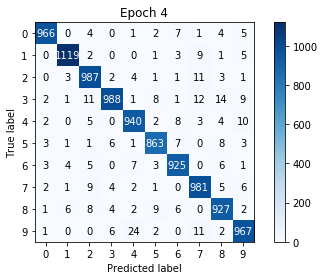

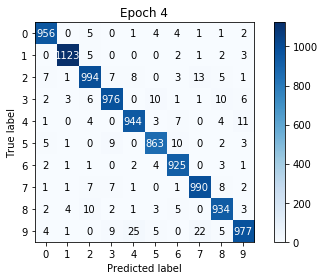

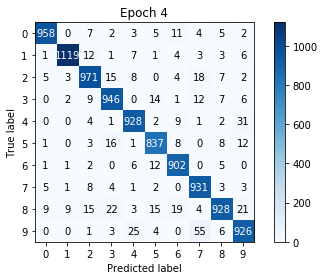

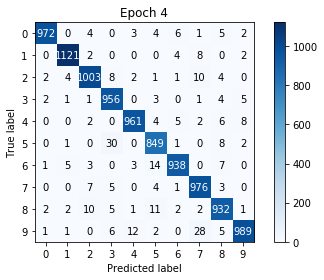

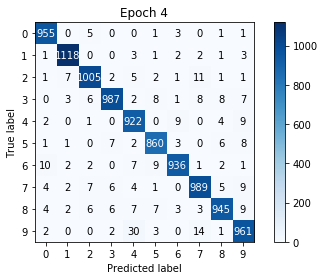

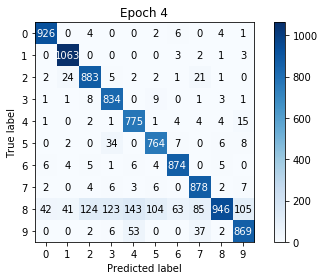

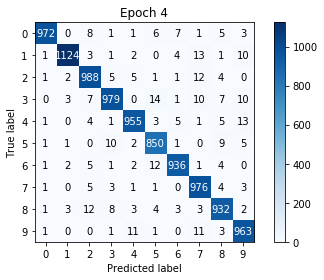

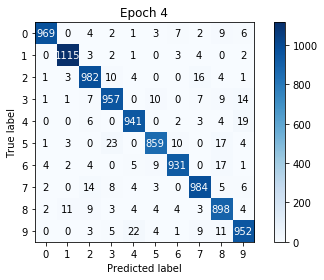

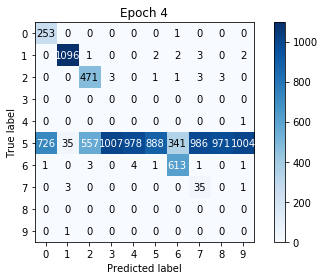

In [18]:
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")

# Loading and visualising a model

In [29]:
model_load = mlflow.pytorch.load_model('models')

In [30]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [31]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

In [32]:
print(weight_layer0.shape) #(48,784)

(48, 784)


The following diagram shows histogram of layers. It has mean of zero and very equally on both the sides.So this is a good sign as theweight are not biased. 

/home/shariq/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/shariq/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


[]

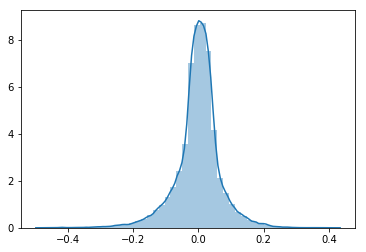

In [33]:
sns.distplot(weight_layer0.ravel())
plt.plot()

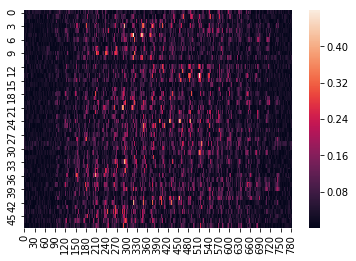

In [34]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [35]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [36]:
weight_layer1.shape

(10, 48)

The following diagram shows the heatmap on weight layer1.

[]

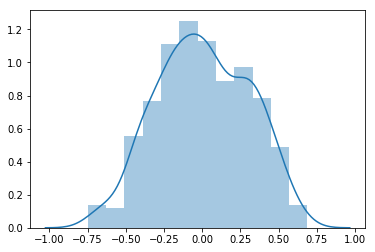

In [37]:
sns.distplot(weight_layer1.ravel())
plt.plot()

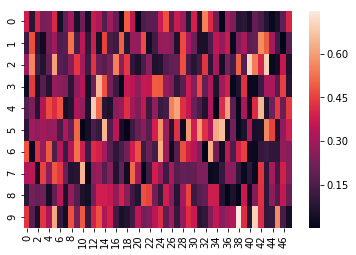

In [38]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

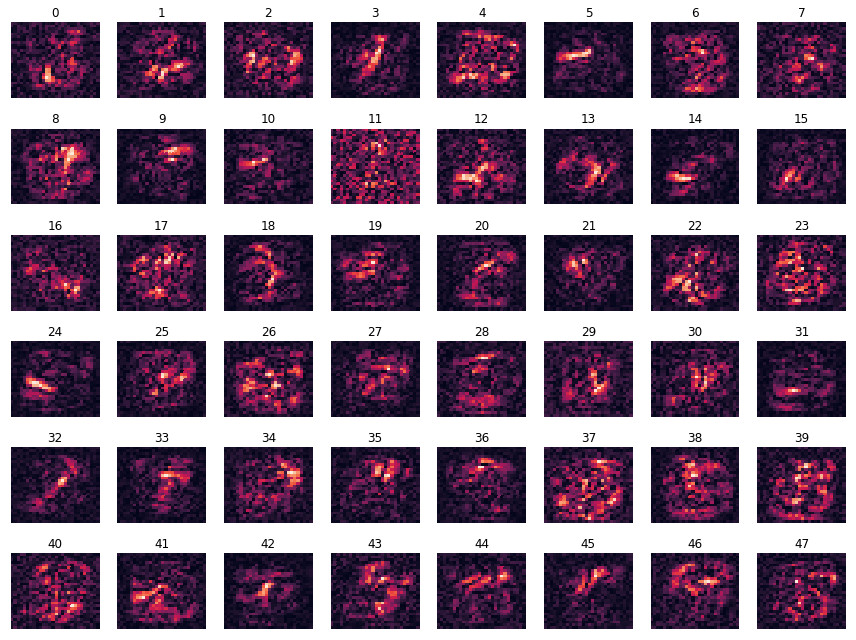

In [39]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()

The diagram above shows what the weight0 layer .The dimension was 784,48. So we have 48 plots and each is of size 784. The plot 11 did not learn anything significant.